# CatBoost Regression Demo



In [1]:
pip install -U catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.1/27.1 MB 8.9 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [44]:
import catboost

print(catboost.__version__)

1.2.7


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## Load Data and Preprocessing

https://www.kaggle.com/datasets/thedevastator/prediction-of-insurance-charges-using-age-gender

In [54]:
insurance_data = pd.read_csv('insurance.csv')

insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [55]:
insurance_data.shape

(1338, 7)

In [56]:
insurance_data.isnull().sum()

age         0
sex         2
bmi         0
children    0
smoker      1
region      2
charges     0
dtype: int64

In [57]:
X = insurance_data.drop('charges', axis=1)

y = insurance_data['charges']

Other than `duration` and `days_left` all other features are categorical

In [58]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1336 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1336 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 62.8+ KB


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((1070, 6), (268, 6))

You must not manually encode (e.g., label encode or one-hot encode) categorical columns before passing them to CatBoost — doing so removes the advantages of its native handling.

If your data is in CSV or NumPy and you don't use pandas, you must specify categorical features by index.

In [60]:
cat_features = X_train.select_dtypes(include='object').columns.tolist()

cat_features

['sex', 'smoker', 'region']

CatBoost's native categorical encoding expects all categorical values to be strings.

Even missing values (NaN) to be explicitly represented as the string 'nan', not as actual np.nan.

You should convert all object-type categorical columns to strings, and explicitly convert NaN to 'nan' (a string).

In [61]:
for col in cat_features:
    X_train[col] = X_train[col].astype(str).fillna('nan')
    X_test[col] = X_test[col].astype(str).fillna('nan')

In [62]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)

test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [63]:
model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=20
)

model.fit(train_pool)

0:	learn: 11131.4972651	total: 7.17ms	remaining: 1.43s
20:	learn: 4865.9620877	total: 58.2ms	remaining: 496ms
40:	learn: 4390.8127179	total: 89.5ms	remaining: 347ms
60:	learn: 4289.8396830	total: 117ms	remaining: 266ms
80:	learn: 4217.5644725	total: 139ms	remaining: 205ms
100:	learn: 4151.2047582	total: 165ms	remaining: 162ms
120:	learn: 4037.5768034	total: 194ms	remaining: 127ms
140:	learn: 3945.2295008	total: 241ms	remaining: 101ms
160:	learn: 3892.8692667	total: 257ms	remaining: 62.3ms
180:	learn: 3828.8975749	total: 296ms	remaining: 31.1ms
199:	learn: 3760.1923162	total: 321ms	remaining: 0us


## Evaluate Model Performance

We predict on the test set and compute the following regression metrics:

- **Mean Absolute Error (MAE)**
- **Mean Squared Error (MSE)**
- **Root Mean Squared Error (RMSE)**
- **R2 Score**

We also plot the Actual vs. Predicted values to visually assess the model performance.

In [66]:
def compute_metrics(model):
    y_pred = model.predict(test_pool)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R2 Score: {r2}")

    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs. Predicted Price')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.show()

MAE: 2294.6629317190527
MSE: 18723284.472430564
RMSE: 4327.041075888992
R2 Score: 0.879398148425949


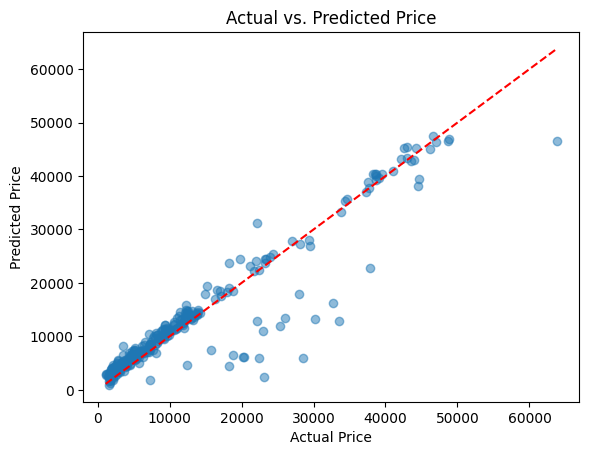

In [67]:
compute_metrics(model)

## Early stopping

Early stopping needs a validation set

In [68]:
X_train_es, X_val, y_train_es, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_es.shape, X_val.shape

((856, 6), (214, 6))

In [69]:
train_pool = Pool(X_train_es, y_train_es, cat_features=cat_features)

val_pool = Pool(X_val, y_val, cat_features=cat_features)

test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [70]:
%%time

model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    bootstrap_type='Bernoulli',
    subsample=0.8,
    verbose=50
)

model.fit(train_pool, eval_set=val_pool)

0:	learn: 11414.0354093	test: 12209.4456116	best: 12209.4456116 (0)	total: 1.33ms	remaining: 397ms
50:	learn: 4539.6453047	test: 5467.7525412	best: 5467.7525412 (50)	total: 97.4ms	remaining: 476ms
100:	learn: 4124.1624433	test: 5284.7863847	best: 5282.8616552 (99)	total: 132ms	remaining: 261ms
150:	learn: 3910.8618897	test: 5273.7297853	best: 5273.5307368 (146)	total: 177ms	remaining: 174ms
200:	learn: 3701.4818351	test: 5301.9306639	best: 5268.2152021 (160)	total: 229ms	remaining: 113ms
250:	learn: 3529.4797601	test: 5349.6478661	best: 5268.2152021 (160)	total: 279ms	remaining: 54.5ms
299:	learn: 3379.4050142	test: 5380.9799716	best: 5268.2152021 (160)	total: 336ms	remaining: 0us

bestTest = 5268.215202
bestIteration = 160

Shrink model to first 161 iterations.
CPU times: user 266 ms, sys: 34.5 ms, total: 301 ms
Wall time: 383 ms


MAE: 2377.921950900942
MSE: 18076181.513206795
RMSE: 4251.6092851068515
R2 Score: 0.8835663174860489


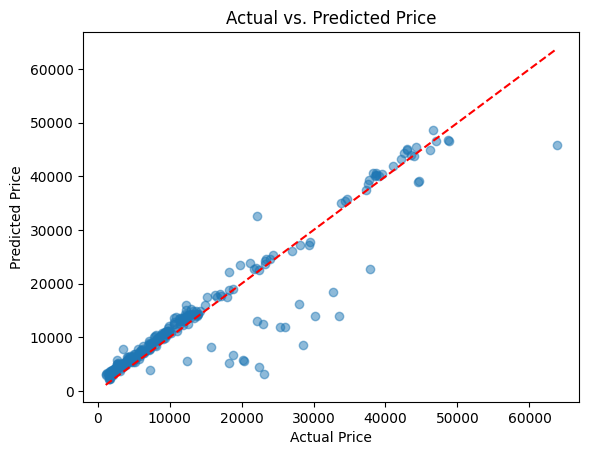

In [71]:
compute_metrics(model)

In [72]:
%%time

model_es = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    bootstrap_type='Bernoulli',
    subsample=0.8,
    od_type='Iter',
    od_wait=40,
    verbose=50
)

model_es.fit(train_pool, eval_set=val_pool)

0:	learn: 11414.0354093	test: 12209.4456116	best: 12209.4456116 (0)	total: 13ms	remaining: 3.9s
50:	learn: 4539.6453047	test: 5467.7525412	best: 5467.7525412 (50)	total: 70.7ms	remaining: 345ms
100:	learn: 4124.1624433	test: 5284.7863847	best: 5282.8616552 (99)	total: 127ms	remaining: 249ms
150:	learn: 3910.8618897	test: 5273.7297853	best: 5273.5307368 (146)	total: 182ms	remaining: 179ms
200:	learn: 3701.4818351	test: 5301.9306639	best: 5268.2152021 (160)	total: 253ms	remaining: 124ms
Stopped by overfitting detector  (40 iterations wait)

bestTest = 5268.215202
bestIteration = 160

Shrink model to first 161 iterations.
CPU times: user 306 ms, sys: 143 ms, total: 449 ms
Wall time: 284 ms


MAE: 2377.921950900942
MSE: 18076181.513206795
RMSE: 4251.6092851068515
R2 Score: 0.8835663174860489


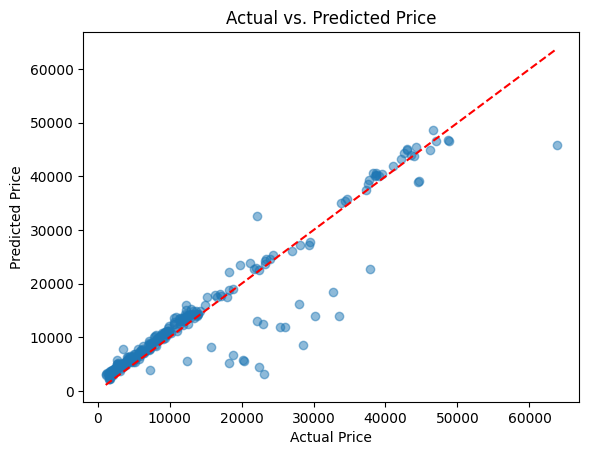

In [73]:
compute_metrics(model_es)

## Feature Importance Analysis

We analyze feature importance using two different methods provided by CatBoost:

- **PredictionValuesChange**: How much each feature contributes to the change in prediction values.
- **LossFunctionChange**: How each feature influences the loss function.

These visualizations help us interpret which features are most influential in predicting house values.

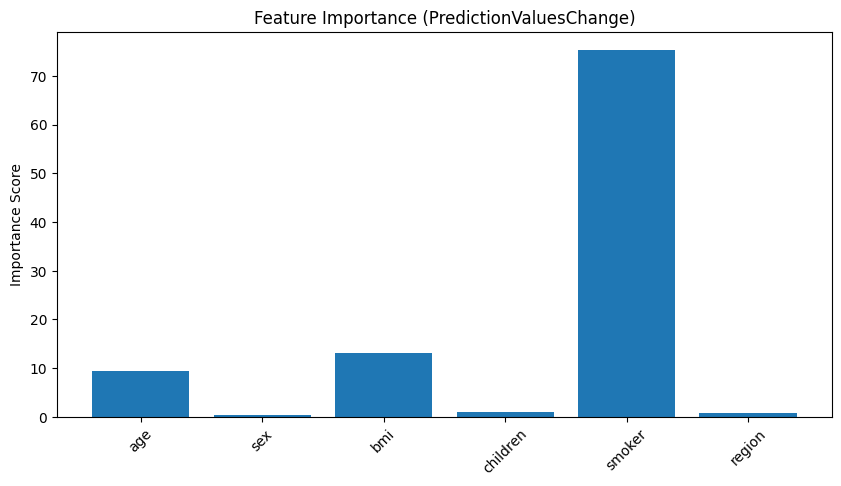

In [74]:
importances_pvc = model.get_feature_importance(train_pool, type='PredictionValuesChange')
features = X_train.columns

plt.figure(figsize=(10, 5))
plt.bar(features, importances_pvc)
plt.title('Feature Importance (PredictionValuesChange)')
plt.xticks(rotation=45)
plt.ylabel('Importance Score')
plt.show()

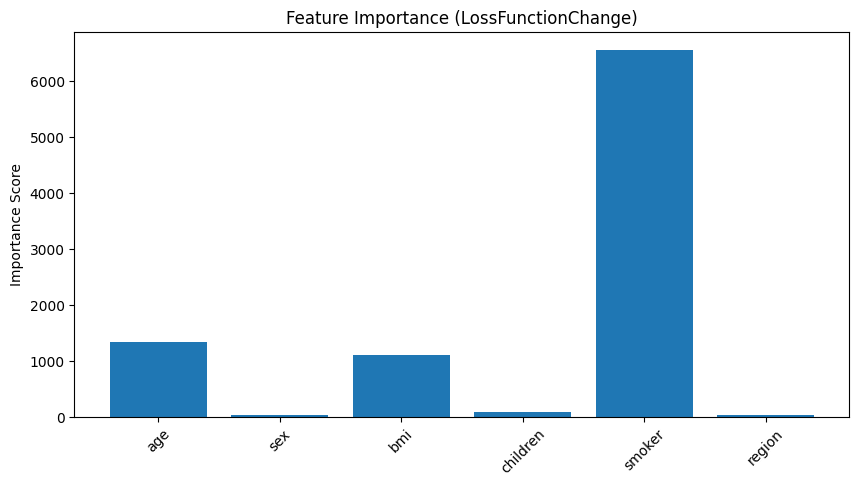

In [75]:
importances_lfc = model.get_feature_importance(train_pool, type='LossFunctionChange')

plt.figure(figsize=(10, 5))
plt.bar(features, importances_lfc)
plt.title('Feature Importance (LossFunctionChange)')
plt.xticks(rotation=45)
plt.ylabel('Importance Score')
plt.show()

## Snapshot Support

In [76]:
params = {
    'iterations': 5,
    'learning_rate': 0.5,
    'depth': 6,
    'loss_function': 'RMSE',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8,
    'logging_level': 'Verbose' 
}

In [77]:
model = CatBoostRegressor(**params).fit(
    train_pool, eval_set=val_pool, save_snapshot=True)

0:	learn: 7715.1550706	test: 8522.1324187	best: 8522.1324187 (0)	total: 1.73ms	remaining: 6.93ms
1:	learn: 5795.5383820	test: 6590.3182168	best: 6590.3182168 (1)	total: 3.46ms	remaining: 5.18ms
2:	learn: 5274.0651898	test: 6147.6864116	best: 6147.6864116 (2)	total: 3.87ms	remaining: 2.58ms
3:	learn: 4694.9351354	test: 5552.8755915	best: 5552.8755915 (3)	total: 4.95ms	remaining: 1.24ms
4:	learn: 4414.5201033	test: 5352.1075277	best: 5352.1075277 (4)	total: 5.87ms	remaining: 0us

bestTest = 5352.107528
bestIteration = 4



### Recording:

- Go to the directory where the code is running
- Show the `catboost_info` folder which is used to track the training process

In [78]:
params.update({
    'iterations': 20,
    'learning_rate': 0.1,
})

model = CatBoostRegressor(**params).fit(
    train_pool, eval_set=val_pool, save_snapshot=True)

5:	learn: 4387.7281950	test: 5339.4474244	best: 5339.4474244 (5)	total: 7.59ms	remaining: 24.1ms
6:	learn: 4358.2241649	test: 5328.8149780	best: 5328.8149780 (6)	total: 9.35ms	remaining: 22.6ms
7:	learn: 4337.7950335	test: 5324.9906033	best: 5324.9906033 (7)	total: 11.3ms	remaining: 21.8ms
8:	learn: 4322.1225730	test: 5321.0197037	best: 5321.0197037 (8)	total: 12.5ms	remaining: 18.1ms
9:	learn: 4305.4357663	test: 5314.7263431	best: 5314.7263431 (9)	total: 13.6ms	remaining: 15.5ms
10:	learn: 4294.9486435	test: 5313.3350035	best: 5313.3350035 (10)	total: 14.3ms	remaining: 12.6ms
11:	learn: 4288.2110789	test: 5312.2211950	best: 5312.2211950 (11)	total: 14.8ms	remaining: 10.2ms
12:	learn: 4270.6525807	test: 5314.0036122	best: 5312.2211950 (11)	total: 15.9ms	remaining: 8.8ms
13:	learn: 4267.7077572	test: 5311.1395102	best: 5311.1395102 (13)	total: 16.6ms	remaining: 7.12ms
14:	learn: 4262.0381057	test: 5308.6292023	best: 5308.6292023 (14)	total: 17.1ms	remaining: 5.63ms
15:	learn: 4247.81536